# Calculate estimate for the site level N<sub>2</sub>O and CH<sub>4</sub> flux

We are going to first calculate the contribution of different surface types for the whole site and then use these parameters together with the best statistical models to calculate annual (snow free period) flux of both GHGs

In [1]:
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import xarray as xr

import ipywidgets as widgets

from shapely.geometry import Point, Polygon
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime

import cloudpickle

import pymc as pm
import arviz as az

sns.set_context('notebook', font_scale=1.5)

%matplotlib widget

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load soil class data

In [2]:
SOILCLASSIFICATION_DATA = os.getenv('SOILCLASSIFICATION_DATA')
ONEDRIVE_FOLDER = os.getenv('ONEDRIVE_FOLDER')

In [3]:
data_soilclass = gpd.read_file(SOILCLASSIFICATION_DATA)

In [4]:
data_overlay = gpd.read_file('data/soilclass_fpr_grid_overlay.shp')

In [5]:
soil_classes = ['Fallen tree','Dry branch','Exposed peat','Light moss','Dark moss','Green vegetation','Ditch', 'Tree', 'Covered ditch','Instruments']

In [6]:
data_overlay = data_overlay.assign(area = data_overlay.area)

In [7]:
total_area = data_overlay.area.sum()

In [8]:
total_area_ha = total_area * 1e-4

In [9]:
st_numbers = np.sort(data_overlay.classInt.unique())

st_cont = []
for st in st_numbers:
    st_cont.append(data_overlay.query(f'classInt == {st}').area.sum())

In [10]:
st_cont

[14744.495249450481,
 5110.073148476494,
 18731.90568226982,
 12853.739435592737,
 917.4699542001658,
 7610.648240184179,
 1201.524679109369,
 2706.5470932373,
 697.5889031456716,
 6.859051457552896]

In [11]:
for st_name,area in zip(soil_classes, st_cont):
    print(f'{st_name}: {np.round(area,0)} : {np.round(area/total_area*100,1)}%')

Fallen tree: 14744.0 : 22.8%
Dry branch: 5110.0 : 7.9%
Exposed peat: 18732.0 : 29.0%
Light moss: 12854.0 : 19.9%
Dark moss: 917.0 : 1.4%
Green vegetation: 7611.0 : 11.8%
Ditch: 1202.0 : 1.9%
Tree: 2707.0 : 4.2%
Covered ditch: 698.0 : 1.1%
Instruments: 7.0 : 0.0%


In [12]:
st_cont_frac = [area / total_area for area in st_cont]

In [13]:
soil_classes

['Fallen tree',
 'Dry branch',
 'Exposed peat',
 'Light moss',
 'Dark moss',
 'Green vegetation',
 'Ditch',
 'Tree',
 'Covered ditch',
 'Instruments']

## Plot the surface type contributions

In [14]:
cmap = mpl.colormaps['tab10'].resampled(10)
cmap = cmap.colors[:-1, :]

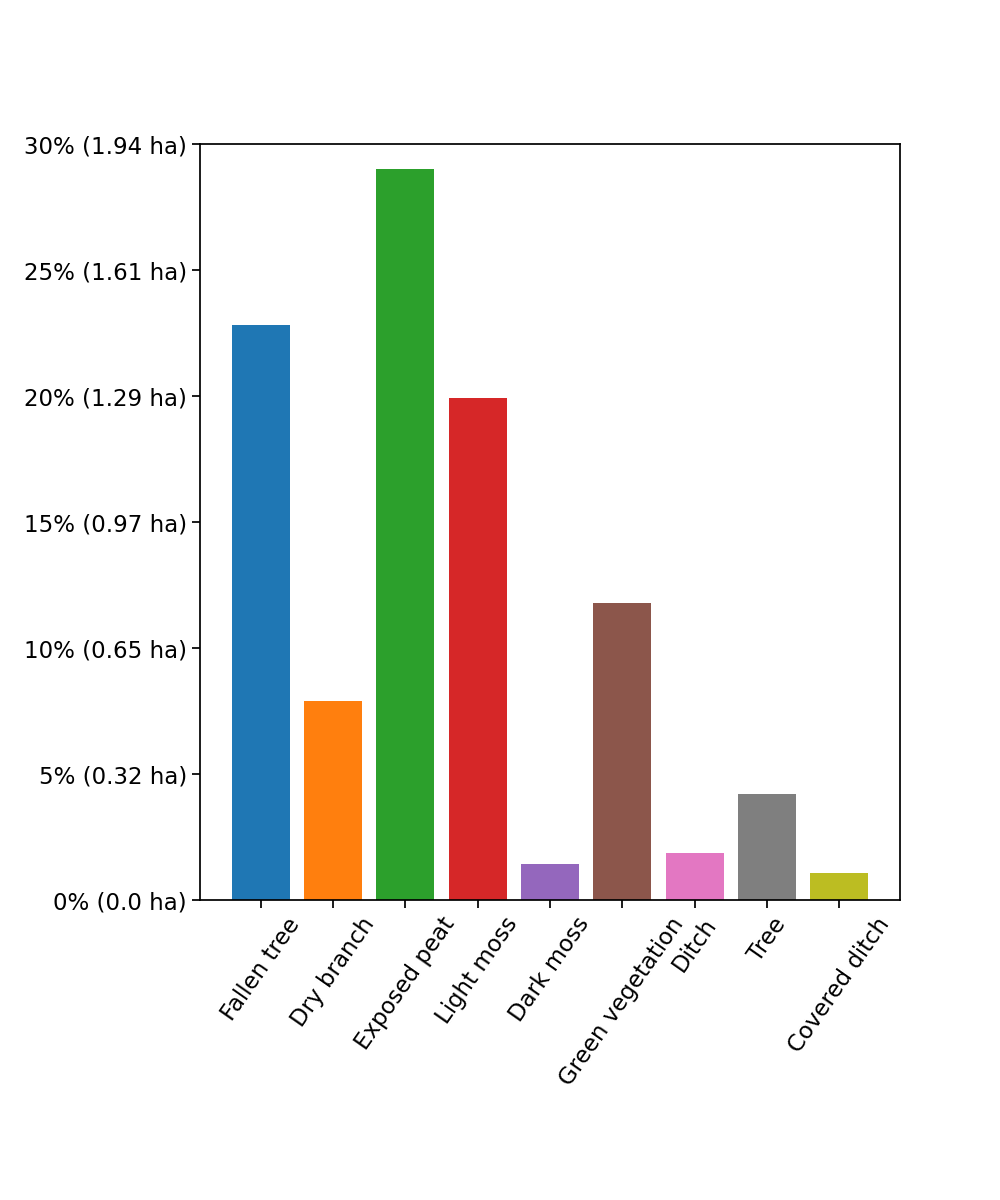

In [15]:
fig, ax = plt.subplots(figsize=(10,12))
fig.subplots_adjust(bottom=0.25, left=0.2)
ax.bar(soil_classes[:-1], st_cont_frac[:-1], color=cmap)
ax.set_xticks(np.arange(9))
ax.set_ylim([0, 0.3])
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{int(i*100)}% ({np.round(j,2)} ha)' for i,j in zip(ax.get_yticks(), ax.get_yticks()*total_area_ha)])
_ = ax.set_xticklabels(soil_classes[:-1], rotation=55)

## Load the models

In [16]:
with open('models/full_model_n2o_st9_mutable.pkl','rb') as buff:
    model_n2o = cloudpickle.load(buff)

with open('models/full_model_ch4_st6_mutable.pkl','rb') as buff:
    model_ch4 = cloudpickle.load(buff)

# Load prediction

In [17]:
pred_n2o = xr.open_dataset('data/n2o_pred_annual_T_air.nc')
pred_ch4 = xr.open_dataset('data/ch4_pred_annual_T_air.nc')

## Load measured data

In [18]:
data_n2o = pd.read_csv('data/inference_data_n2o.csv', index_col='time')
data_n2o.index = pd.to_datetime(data_n2o.index)

data_ch4 = pd.read_csv('data/inference_data_ch4.csv', index_col='time')
data_ch4.index = pd.to_datetime(data_ch4.index)

In [19]:
# For CH4 remove the two datapoints as this makes the model comparison difficult

data_ch4 = data_ch4.loc[data_ch4.F_CH4_ln > -4.1, :]

# Calculate HDI interval

In [20]:
n2o_hdi = az.hdi(pred_n2o,var_names=["pred_real_bias_corrected"], hdi_prob = 0.95)
n2o_median = pred_n2o.pred_real_bias_corrected.median(dim=("chain", "draw"))
ch4_hdi = az.hdi(pred_ch4,var_names=["pred_real_bias_corrected"], hdi_prob = 0.95)
ch4_median = pred_ch4.pred_real_bias_corrected.median(dim=("chain", "draw"))

## Function for calculating the annual balance

In [21]:
# def calculate_annual_budget(params, Tair, shift, x):
    
#     F = params['alpha'].to_numpy()  + (params['beta'].to_numpy())*((Tair[:, 0].flatten() - 283.15)/10) + np.sum(params['gamma'][:, :, :].to_numpy()*x + params['delta'][:, :, :].to_numpy()*((Tair - 283.15)/10)*x, axis=2) + np.random.normal(loc=0, scale=params['sigma'])
#     B = np.sum((np.exp(F)-shift)*1800*1e-6, axis=1) # mol/m2
#     mean = np.mean(B)
#     std = np.std(B)
#     return (mean, std, F)

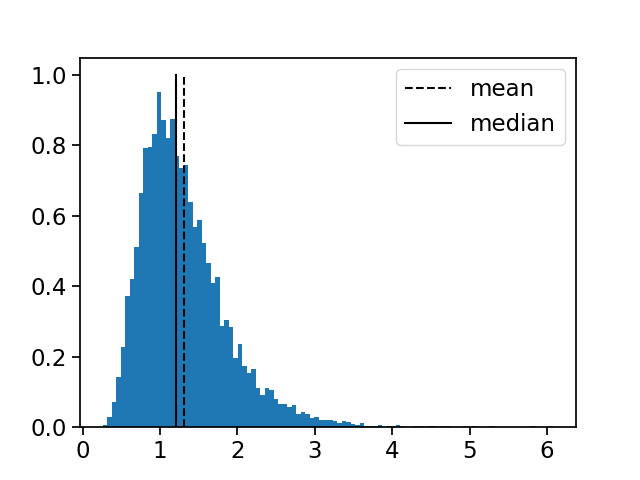

In [22]:
fig, ax = plt.subplots()
vals = pred_n2o.pred_real_bias_corrected[:, :, 7000].data.flatten()
mean = np.mean(vals)
median = np.median(vals)
_ = ax.hist(vals, bins=100, density=True)
ymin, ymax = ax.get_ylim()
ax.plot((mean, mean), (ymin, ymax), 'k--', label='mean')
ax.plot((median ,median), (ymin, ymax), 'k-', label='median')
ax.legend(loc='best')

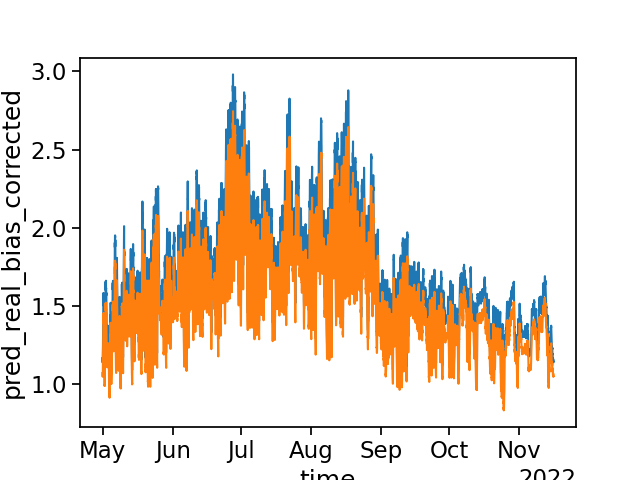

In [23]:
fig, ax = plt.subplots()
pred_n2o.pred_real_bias_corrected.mean(dim=("chain","draw")).plot(ax=ax)
pred_n2o.pred_real_bias_corrected.median(dim=("chain","draw")).plot(ax=ax)

In [24]:
n2o_hdi

<xarray.Dataset>
Dimensions:                   (time: 9553, hdi: 2)
Coordinates:
  * time                      (time) datetime64[ns] 2022-05-01 ... 2022-11-16
  * hdi                       (hdi) <U6 'lower' 'higher'
Data variables:
    pred_real_bias_corrected  (time, hdi) float64 0.4062 2.178 ... 0.3592 2.101

Text(0.5, 0, '')

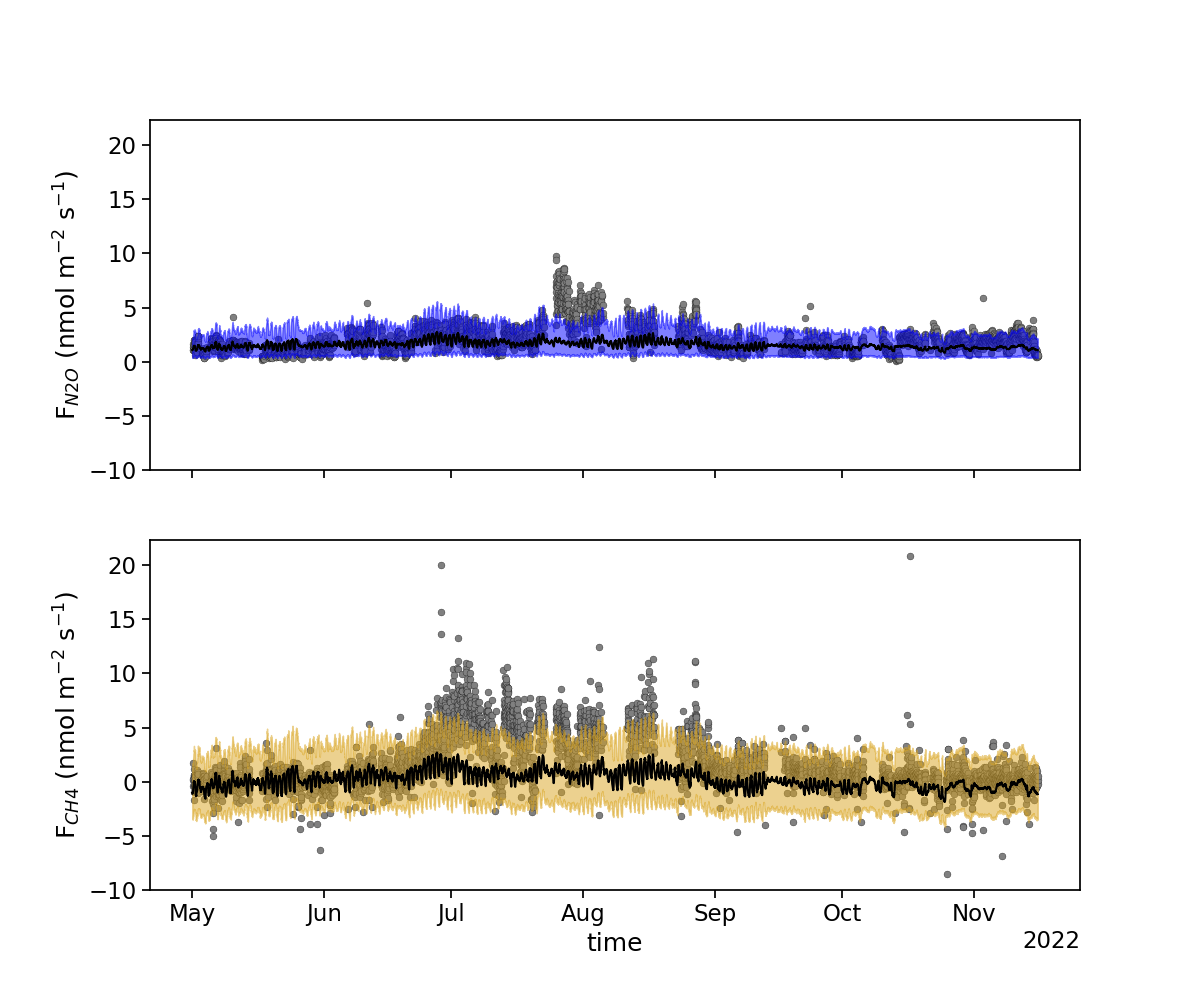

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,10), sharex=True, sharey=True)
axs = axs.flatten()
n2o_median.plot(ax=axs[0], color='black')
ch4_median.plot(ax=axs[1], color='black')

axs[0].plot(data_n2o.index, data_n2o.F_N2O*1000, 'ko', markersize=5, markerfacecolor='gray', markeredgewidth=0.2, zorder=1)
axs[0].fill_between(n2o_hdi.time, n2o_hdi.pred_real_bias_corrected[:, 0], n2o_hdi.pred_real_bias_corrected[:, 1], color='blue', alpha=0.5)

axs[1].plot(data_ch4.index, data_ch4.F_CH4*1000, 'ko', markersize=5, markerfacecolor='gray', markeredgewidth=0.2, zorder=1)
axs[1].fill_between(ch4_hdi.time, ch4_hdi.pred_real_bias_corrected[:, 0], ch4_hdi.pred_real_bias_corrected[:, 1], color='goldenrod', alpha=0.5)
axs[0].set_ylabel('F$_{N2O}$ (nmol m$^{-2}$ s$^{-1}$)')
axs[1].set_ylabel('F$_{CH4}$ (nmol m$^{-2}$ s$^{-1}$)')
axs[0].set_xlabel('')

In [26]:
# def calculate_annual_budget_one_parameter_set(params, Tair, shift, x):
    
#     F = params['alpha']  + (params['beta'])*((Tair[:, 0].flatten() - 283.15)/10) + np.sum(params['gamma']*x + params['delta']*((Tair - 283.15)/10)*x, axis=1)
#     B = np.sum((np.exp(F)-shift)*1800*1e-6) # mol/m2

#     return B

In [27]:
def calculate_budget_time_series(series):
    return ((series*1800).sum()*1e-9/1e-4).data.flatten()[0] # mol/ha

In [28]:
# def calculate_annual_budget_map(params, T, X, shift):
#     F = params['alpha']  + (params['beta'])*((T[:, 0].flatten() - 283.15)/10) + np.sum(params['gamma']*X + params['delta']*((T - 283.15)/10)*X, axis=1)
#     B = np.sum((np.exp(F)-shift)*1800*1e-6) # mol/m2

#     return B

## Load T<sub>air</sub> data

In [29]:
Tair = pd.read_csv('data/T_air_gapfilled.csv')
T = Tair['T_air'].values + 273.15
T = T.reshape(T.shape[0], 1)

# Calculate the best estimate from MAP estimate

In [30]:
# X = np.array(st_cont_frac).reshape(1, -1)
# X = X[:, :-1]

# map_n2o = calculate_annual_budget_map(model_n2o['map'], np.repeat(T, repeats=9, axis=1), np.repeat(X, repeats=T.shape[0], axis=0), 0.001)
# map_ch4 = calculate_annual_budget_map(model_ch4['map'], np.repeat(T, repeats=9, axis=1), np.repeat(X, repeats=T.shape[0], axis=0), 0.033)

## Calculate annual balance using out-of-model prediction set HDI

In [31]:
# lower_n2o = calculate_budget_time_series(n2o_hdi.pred[:, 0], 0.001).item()
# higher_n2o = calculate_budget_time_series(n2o_hdi.pred[:, 1], 0.001).item()

# lower_ch4 = calculate_budget_time_series(ch4_hdi.pred[:, 0], 0.033).item()
# higher_ch4 = calculate_budget_time_series(ch4_hdi.pred[:, 1], 0.033).item()

In [32]:
n2o_median

<xarray.DataArray 'pred_real_bias_corrected' (time: 9553)>
array([1.07160703, 1.0592489 , 1.04771833, ..., 1.04876624, 1.05242214,
       1.05074166])
Coordinates:
  * time     (time) datetime64[ns] 2022-05-01 2022-05-01T00:30:00 ... 2022-11-16

In [33]:
median_balance_n2o = calculate_budget_time_series(n2o_median)
lower_balance_n2o = calculate_budget_time_series(n2o_hdi.pred_real_bias_corrected[:, 0])
higher_balance_n2o = calculate_budget_time_series(n2o_hdi.pred_real_bias_corrected[:, 1])

In [34]:
(median_balance_n2o, lower_balance_n2o, higher_balance_n2o) # mol/ha

(264.7927053531711, 93.97907333244578, 534.4584451968659)

In [35]:
M_n2o = 0.044013 #kg/mol
(median_balance_n2o*M_n2o, lower_balance_n2o*M_n2o, higher_balance_n2o*M_n2o) # kg/ha

(11.654321340709117, 4.1363009545809355, 23.523119548449657)

In [36]:
GWP100_n2o = 265 #kgCO2eq/kgN2O
(median_balance_n2o*M_n2o*GWP100_n2o, lower_balance_n2o*M_n2o*GWP100_n2o, higher_balance_n2o*M_n2o*GWP100_n2o)# kgCO2eq / ha

(3088.395155287916, 1096.1197529639478, 6233.626680339159)

In [37]:
median_balance_ch4 = calculate_budget_time_series(ch4_median)
lower_balance_ch4 = calculate_budget_time_series(ch4_hdi.pred_real_bias_corrected[:, 0])
higher_balance_ch4 = calculate_budget_time_series(ch4_hdi.pred_real_bias_corrected[:, 1])

In [38]:
(median_balance_ch4, lower_balance_ch4, higher_balance_ch4) # mol/ha

(30.551187687671295, -431.44394846291, 562.2139932098544)

In [39]:
M_ch4 = 0.01604 #kg/mol
(median_balance_ch4*M_ch4, lower_balance_ch4*M_ch4, higher_balance_ch4*M_ch4) # kg / ha

(0.49004105051024754, -6.9203609333450755, 9.017912451086064)

In [40]:
GWP100_ch4 = 28 #kgCO2eq/kgCH4
(median_balance_ch4*M_ch4*GWP100_ch4, lower_balance_ch4*M_ch4*GWP100_ch4, higher_balance_ch4*M_ch4*GWP100_ch4)# kgCO2eq / ha

(13.72114941428693, -193.77010613366213, 252.5015486304098)

# Calculate the measured balance

In [41]:
ONEDRIVE_FOLDER

'/Users/opa/Library/CloudStorage/OneDrive-Valtion/Ranskalankorpi_clearcut_data_shared/'

In [42]:
meas = xr.open_dataset(f'{ONEDRIVE_FOLDER}EC/EC_flux_L3_final_FI-Ran_2022.nc')

In [43]:
meas.n2o_flux_final_gf_ensemble

<xarray.DataArray 'n2o_flux_final_gf_ensemble' (time: 17520)>
[17520 values with dtype=float64]
Coordinates:
  * time     (time) float64 1.899e+04 1.899e+04 ... 1.936e+04 1.936e+04
Attributes:
    unit:       µmol+1s-1m-2
    long_name:  n2o_flux_final time series gapfilled with ensemble of machine...

In [44]:
meas['time'] = pd.to_datetime(meas.time, unit="d")

## Select snow free period

In [45]:
meas_sf = meas.sel(time=slice(datetime(2022,5,1,0,0), datetime(2022,11,16,0,0)))

In [46]:
co2_meas = ((meas_sf.co2_flux_final_gf_ensemble*1800*1e-6).sum()/1e-4).to_numpy().flatten()[0]

In [47]:
GPP_meas = ((meas_sf.GPP_gf_ensemble_NT*1800*1e-6).sum()/1e-4).to_numpy().flatten()[0]

In [48]:
Reco_meas = ((meas_sf.Reco_gf_ensemble_NT*1800*1e-6).sum()/1e-4).to_numpy().flatten()[0]

In [49]:
n2o_meas = ((meas_sf.n2o_flux_final_gf_ensemble*1800*1e-6).sum()/1e-4).to_numpy().flatten()[0]

In [50]:
ch4_meas = ((meas_sf.ch4_flux_final_gf_ensemble*1800*1e-6).sum()/1e-4).to_numpy().flatten()[0]

In [51]:
M_co2 = 0.04401
co2_meas*M_co2

19193.358536531767

In [52]:
GPP_meas*M_co2

14492.476055923946

In [53]:
Reco_meas*M_co2

33685.83459245572

In [54]:
GPP_meas/Reco_meas

0.4302246398600343

In [55]:
n2o_meas * M_n2o

14.700072334992926

In [56]:
n2o_meas*M_n2o*GWP100_n2o

3895.5191687731253

In [57]:
ch4_meas*M_ch4

3.5133367925786474

In [58]:
ch4_meas*M_ch4*GWP100_ch4

98.37343019220212

In [59]:
data = xr.open_dataset(f'{ONEDRIVE_FOLDER}EC/EC_flux_L2_final_FI-Ran_2022.nc')

Text(0.5, 0, 'Wind direction ($^{\\circ}$)')

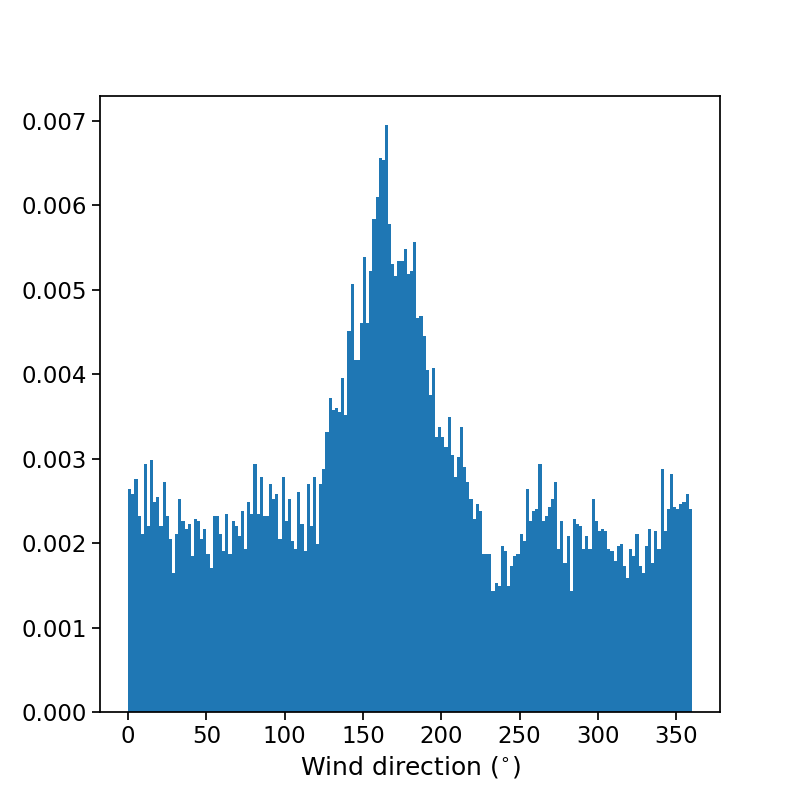

In [60]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.hist(data.wind_dir.values, bins=np.linspace(0,360,181), density=True)
ax.set_xlabel('Wind direction ($^{\circ}$)')